In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from pandas import DataFrame
from pandas import concat
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('kings.csv',index_col=0, skipinitialspace=False)

In [5]:
df.head()

,Lifespan
Obs_No,
1,60
2,43
3,67
4,50
5,56


In [6]:
df.isnull().sum()

Lifespan    0
dtype: int64

In [7]:
df.shape

(42, 1)

In [8]:
df.describe()

,Lifespan
count,42.000000
mean,55.285714
std,16.569566
min,13.000000
25%,44.000000
50%,56.000000
75%,67.750000
max,86.000000


In [9]:
df.skew()

Lifespan   -0.458668
dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 42
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Lifespan  42 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes


<AxesSubplot:>

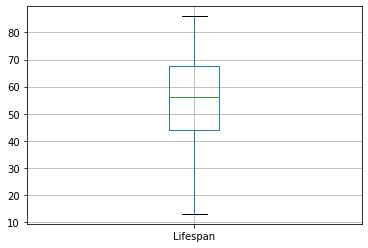

In [11]:
df.boxplot()

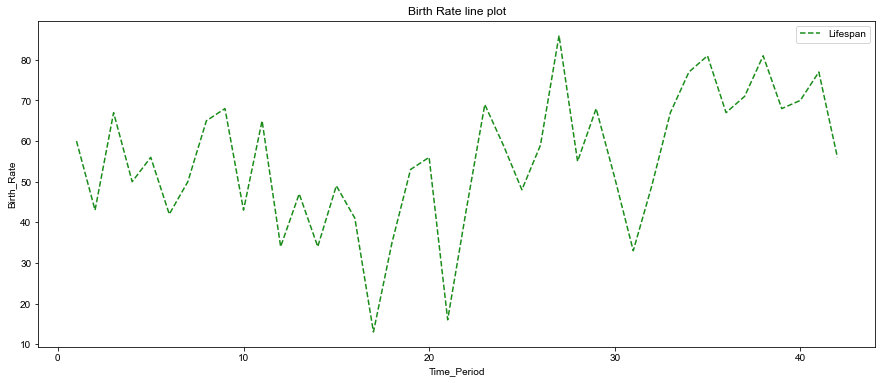

In [12]:
df.plot(figsize=(15, 6),color='green',linestyle='--', alpha=0.9, linewidth = 1.5)
plt.xlabel("Time_Period")
plt.ylabel("Birth_Rate")
plt.title('Birth Rate line plot')
plt.style.use('seaborn-whitegrid')
plt.show()

### `Adfuller Test `

In [15]:
timeseries = adfuller(df)
print('ADF Statistic: %f' % timeseries[0])
print('p-value: %f' % timeseries[1])
print('Critical Values:')
for key, value in timeseries[4].items():
    print('\t%s: %.3f' % (key, value))
if timeseries[0] > timeseries[4]["5%"]:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
else:
    print("Reject Ho - Time Series is Stationary")

ADF Statistic: -4.090230
p-value: 0.001005
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
Reject Ho - Time Series is Stationary


### `Creating train and test set `

In [17]:
train=df[0:28]
test=df[28:41]

In [19]:
test.shape

(13, 1)

In [20]:
train.shape

(28, 1)

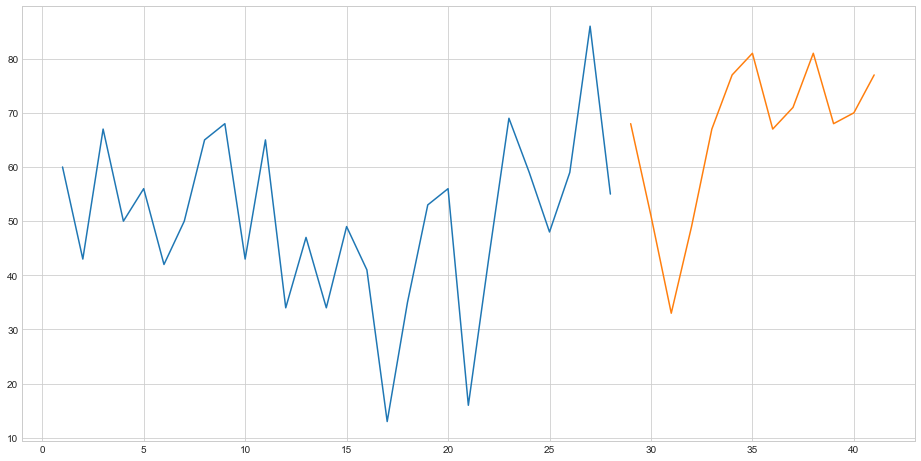

In [22]:
plt.figure(figsize=(16,8))
plt.plot( train['Lifespan'], label='Train')
plt.plot(test['Lifespan'], label='Test')

## Moving Average

In [24]:
from pandas import concat

width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
print(dataframe.head(10))

             mean   t-1  t+1
Obs_No                      
1             NaN   NaN   60
2             NaN  60.0   43
3             NaN  43.0   67
4             NaN  67.0   50
5       56.666667  50.0   56
6       53.333333  56.0   42
7       57.666667  42.0   50
8       49.333333  50.0   65
9       49.333333  65.0   68
10      52.333333  68.0   43


In [25]:
df = pd.DataFrame(df)

In [26]:
df.head()

,Lifespan
Obs_No,
1,60
2,43
3,67
4,50
5,56


## ARIMA

                             ARIMA Model Results                              
Dep. Variable:             D.Lifespan   No. Observations:                   41
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -168.137
Method:                       css-mle   S.D. of innovations             14.148
Date:                Tue, 19 Jan 2021   AIC                            352.274
Time:                        12:07:53   BIC                            365.982
Sample:                             1   HQIC                           357.266
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4424      0.350      1.264      0.206      -0.244       1.128
ar.L1.D.Lifespan     0.2896      0.160      1.805      0.071      -0.025       0.604
ar.L2.D.Lifespan     0.0290 

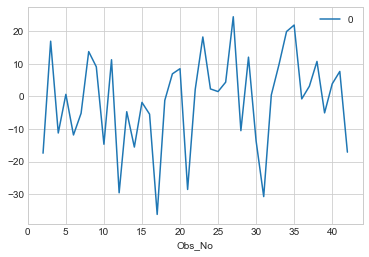

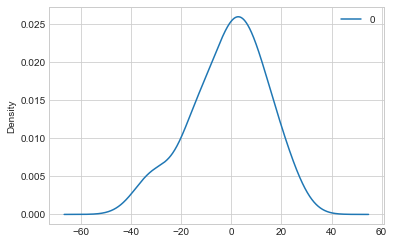

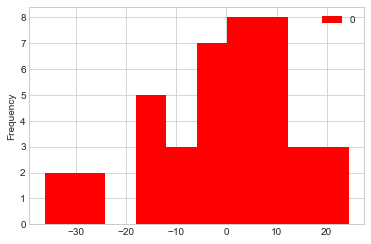

               0
count  41.000000
mean   -1.280969
std    14.735641
min   -36.223361
25%   -11.241855
50%     0.615483
75%     9.067008
max    24.425279


In [27]:
x = df['Lifespan']
# fit model
model = ARIMA(x, order=(5,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

residuals.plot(kind = 'hist', color = 'red')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [30]:
df.head()

,Lifespan,forecast
Obs_No,,
1,60,NaN
2,43,NaN
3,67,NaN
4,50,NaN
5,56,NaN


<AxesSubplot:xlabel='Obs_No'>

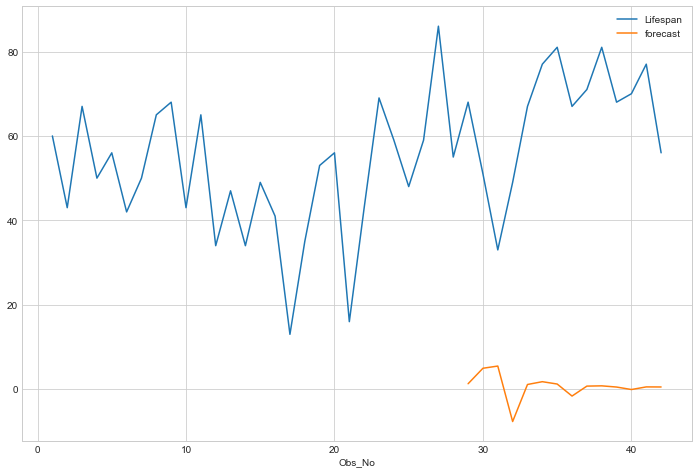

In [31]:
df['forecast']=model_fit.predict(start=28,end=41,dynamic=True)
df[['Lifespan','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Obs_No'>

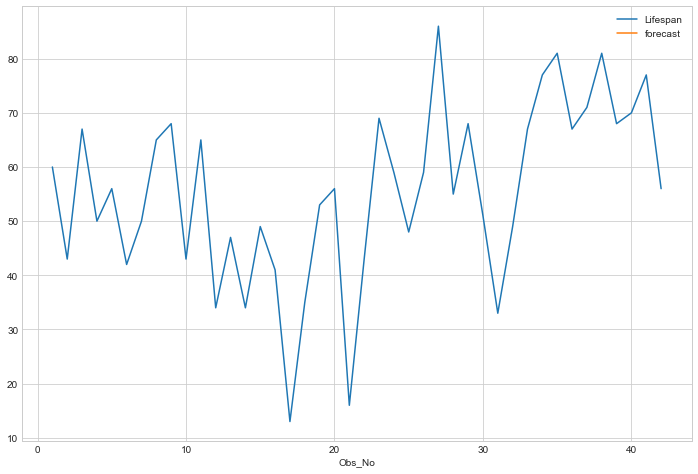

In [32]:
model=sm.tsa.statespace.SARIMAX(df['Lifespan'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=100,end=168,dynamic=True)
df[['Lifespan','forecast']].plot(figsize=(12,8))

In [34]:
res = sm.tsa.ARMA(df['Lifespan'], (1,1)).fit(disp=-1)
sm.stats.acorr_ljungbox(res.resid, lags=[12], return_df=True)
#sm.stats.acorr_ljungbox(res.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,6.723451,0.875335


# Weighted Moving Average

In [35]:
train=df[0:28] 
test=df[28:41]

In [36]:
weights = np.arange(1,11) #this creates an array with integers 1 to 10 included
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [37]:
wma10 = train['Lifespan'].rolling(10).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
wma10.head(20)

Obs_No
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10    54.381818
11    56.309091
12    52.509091
13    51.236364
14    47.963636
15    47.709091
16    46.127273
17    39.472727
18    37.490909
19    39.327273
20    41.981818
Name: Lifespan, dtype: float64

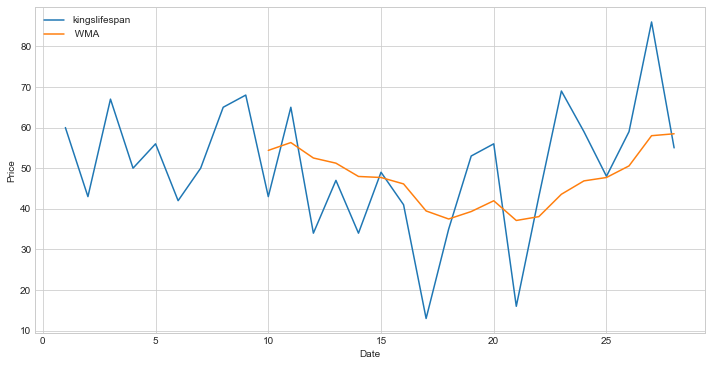

In [38]:
plt.figure(figsize = (12,6))
plt.plot(train['Lifespan'], label="kingslifespan")
plt.plot(wma10, label=" WMA")

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Exponential Smoothening

In [39]:
train=df[0:28] 
test=df[28:41]

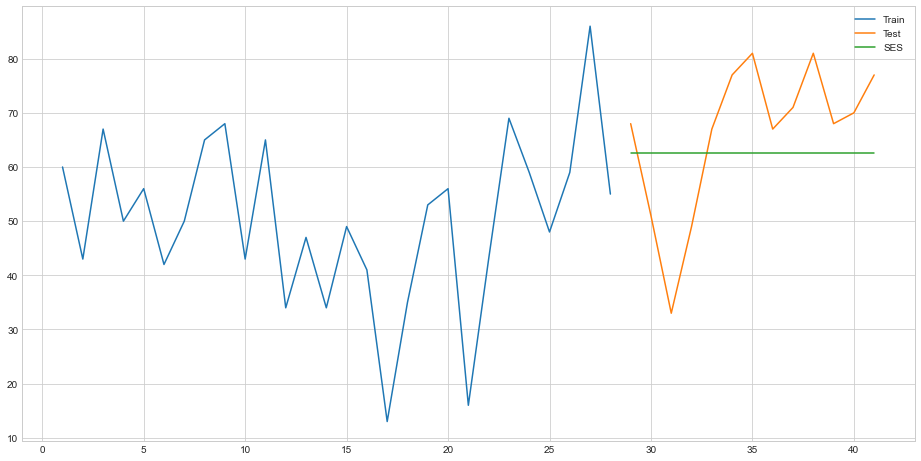

In [40]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Lifespan'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Lifespan'], label='Train')
plt.plot(test['Lifespan'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [41]:
rms = sqrt(mean_squared_error(test.Lifespan, y_hat_avg.SES))
print('RMSE:', rms)

RMSE: 13.886633395812916


### `Holt's Winter Method`

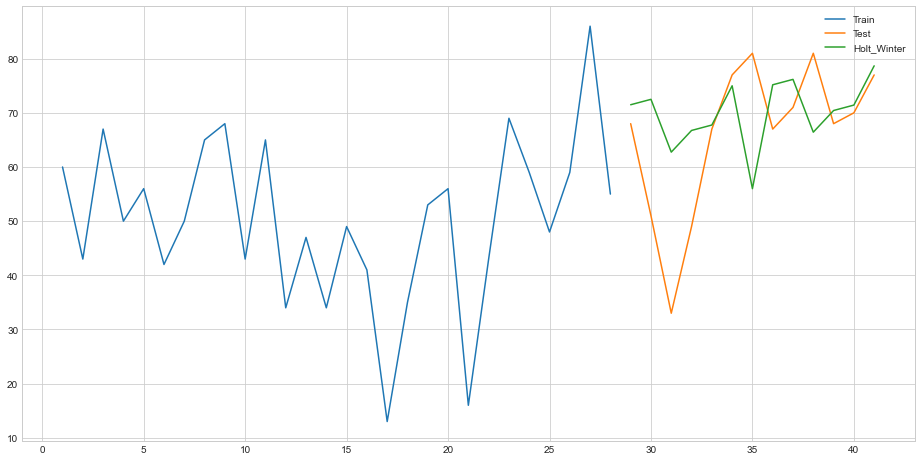

In [42]:
y_hat_avg = test.copy()
fit = ExponentialSmoothing(np.asarray(train['Lifespan']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Lifespan'], label='Train')
plt.plot(test['Lifespan'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

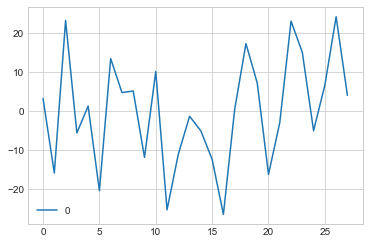

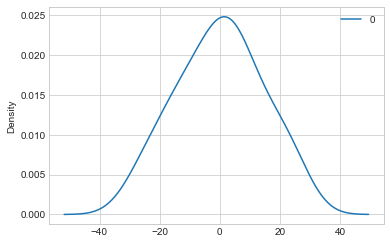

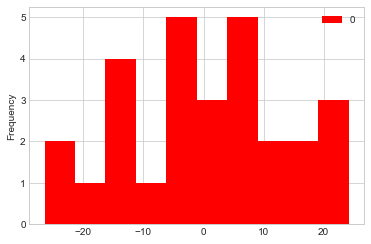

               0
count  28.000000
mean   -0.000049
std    14.160171
min   -26.449424
25%   -11.220708
50%     0.868549
75%     7.958334
max    24.178050


In [43]:
residuals = pd.DataFrame(fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

residuals.plot(kind = 'hist', color = 'red')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [56]:
# ljungbox test

sm.stats.acorr_ljungbox(residuals, lags=[16], return_df=True)


,lb_stat,lb_pvalue
16,21.257328,0.16883


In [57]:
rms = sqrt(mean_squared_error(test.Lifespan, y_hat_avg.Holt_Winter))
print('RMSE:', rms)

RMSE: 14.197904012909069


In [59]:
y_hat_avg[['Lifespan', 'Holt_Winter']]

,Lifespan,Holt_Winter
Obs_No,,
29,68,71.495465
30,51,72.494909
31,33,62.746167
32,49,66.746921
33,67,67.748973
34,77,74.998173
35,81,55.997029
36,67,75.178900
37,71,76.178344


### `AUTO CORRELATION AND PARTIAL AUTO CORRELATION PLOT` 

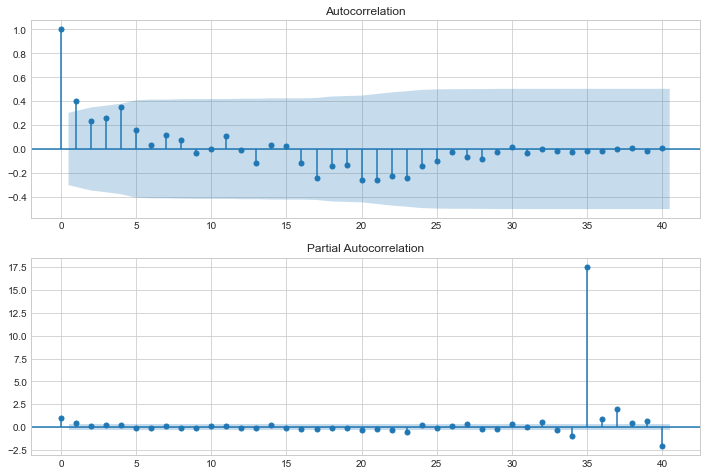

In [60]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Lifespan'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Lifespan'],lags=40,ax=ax2)

### `AUTO CORREALTION PLOT`

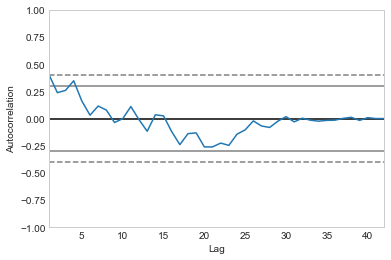

In [61]:
autocorrelation_plot(df['Lifespan'])
plt.show()